# [M1 Mac] Flower-1-Intro-to-FL-PyTorch.ipynb
https://github.com/adap/flower/blob/685ce1445a6895539abbaa01a1f548178ed08faf/doc/source/tutorial/Flower-1-Intro-to-FL-PyTorch.ipynb

In [1]:
from collections import OrderedDict
from typing import List, Tuple

import flwr as fl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from flwr.common import Metrics
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10

DEVICE = torch.device("mps")  # Try "cuda" to train on GPU, "mps" for Apple Metal
print(f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}")

Training on mps using PyTorch 1.13.1 and Flower 1.2.0


In [2]:
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
NUM_CLIENTS = 10

In [4]:
BATCH_SIZE = 32

def load_datasets():
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
      [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
    testset = CIFAR10("./dataset", train=False, download=True, transform=transform)

    # Split training set into 10 partitions to simulate the individual dataset
    partition_size = len(trainset) // NUM_CLIENTS
    lengths = [partition_size] * NUM_CLIENTS
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader

trainloaders, valloaders, testloader = load_datasets()

Files already downloaded and verified
Files already downloaded and verified


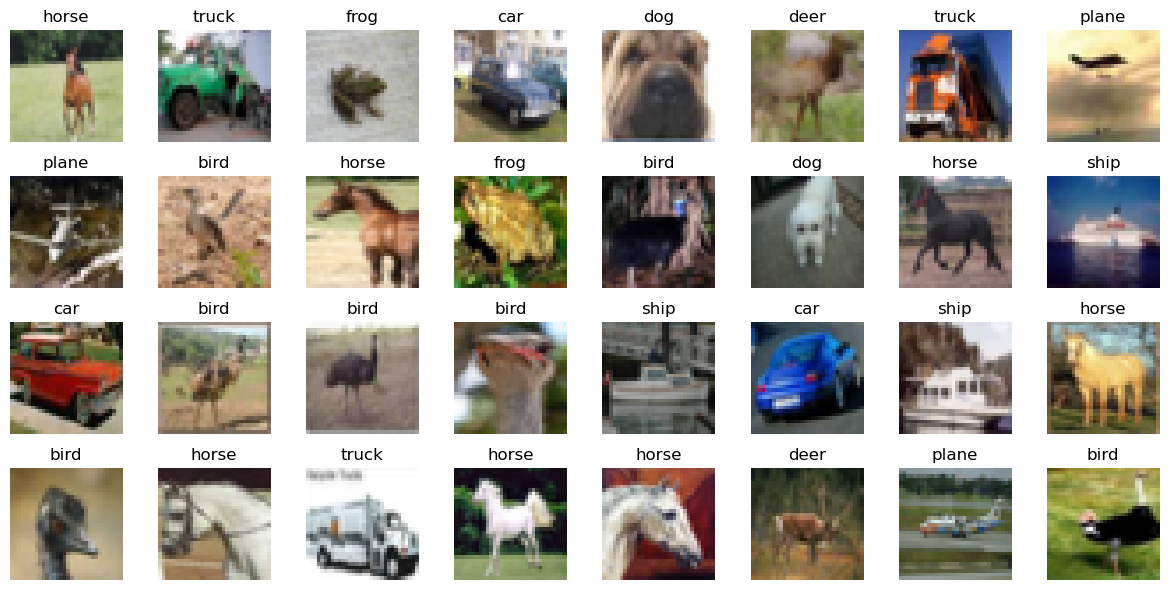

In [5]:
images, labels = next(iter(trainloaders[0]))

# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()
# Denormalize
images = images/2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(CLASSES[labels[i]])
    ax.axis('off')

# Show the plot
fig.tight_layout()
plt.show()

In [6]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [8]:
trainloader = trainloaders[0]
valloader = valloaders[0]
net = Net().to(DEVICE)

for epoch in range(5):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Epoch 1: validation loss 0.060277685403823854, accuracy 0.308
Epoch 2: validation loss 0.054599671840667725, accuracy 0.384
Epoch 3: validation loss 0.053766303062438965, accuracy 0.386
Epoch 4: validation loss 0.05050605916976929, accuracy 0.396
Epoch 5: validation loss 0.05075745153427124, accuracy 0.408
Final test set performance:
	loss 0.048565744531154635
	accuracy 0.4296


In [9]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

In [10]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [11]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)

In [13]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
        fraction_fit=1.0,  # Sample 100% of available clients for training
        fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
        min_fit_clients=10,  # Never sample less than 10 clients for training
        min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
        min_available_clients=10,  # Wait until all 10 clients are available
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "mps":
  client_resources = {"num_gpus": 0}

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-01-23 14:39:10,684 | app.py:142 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-01-23 14:39:15,730	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-01-23 14:39:17,047 | app.py:176 | Flower VCE: Ray initialized with resources: {'memory': 7776600064.0, 'CPU': 8.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0}
INFO flwr 2023-01-23 14:39:17,047 | server.py:86 | Initializing global parameters
INFO flwr 2023-01-23 14:39:17,048 | server.py:270 | Requesting initial parameters from one random client
INFO flwr 2023-01-23 14:39:18,473 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-01-23 14:39:18,473 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-01-23 14:39:18,474 | server.py:101 | FL starting
DEBUG flwr 2023-01-23 14:39:18,474 | server.py:215 | fit_round 1: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-01-23 

History (loss, distributed):
	round 1: 0.06130352649688721
	round 2: 0.055552912092208875
	round 3: 0.052923293209075926
	round 4: 0.05073939018249511
	round 5: 0.049169876956939695

In [14]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [15]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
        fraction_fit=1.0,
        fraction_evaluate=0.5,
        min_fit_clients=10,
        min_evaluate_clients=5,
        min_available_clients=10,
        evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-01-24 15:54:37,478 | app.py:142 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-01-24 15:54:42,697	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-01-24 15:54:44,058 | app.py:176 | Flower VCE: Ray initialized with resources: {'node:127.0.0.1': 1.0, 'CPU': 8.0, 'memory': 7888902554.0, 'object_store_memory': 2147483648.0}
INFO flwr 2023-01-24 15:54:44,059 | server.py:86 | Initializing global parameters
INFO flwr 2023-01-24 15:54:44,060 | server.py:270 | Requesting initial parameters from one random client
INFO flwr 2023-01-24 15:54:45,532 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-01-24 15:54:45,532 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-01-24 15:54:45,533 | server.py:101 | FL starting
DEBUG flwr 2023-01-24 15:54:45,533 | server.py:215 | fit_round 1: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-01-24 

History (loss, distributed):
	round 1: 0.0654045042514801
	round 2: 0.05599202647209167
	round 3: 0.052757033729553225
	round 4: 0.05043449759483337
	round 5: 0.0479925350189209
History (metrics, distributed):
{'accuracy': [(1, 0.2812), (2, 0.35839999999999994), (3, 0.3968), (4, 0.42160000000000003), (5, 0.4364)]}